# DPA (Dual Pipeline Attentional Multimodal Fusion)

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from keras.callbacks import EarlyStopping
from keras.layers import (Activation, Attention, Bidirectional, Concatenate, Conv1D,
                           Dense, Dropout, Embedding, Flatten, GlobalMaxPooling1D,
                           Input, Layer, LSTM, MaxPooling1D, Multiply, Permute,
                           RepeatVector, Reshape, SpatialDropout1D, TimeDistributed)
from keras.models import Model
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords

#import our own library cs16
import sys
sys.path.append('./cs16')
import cs16.prep as prep16
import cs16.plot as plot16
import cs16.build as build16
imagesize = 64

#----------------------------------------------------
# select a dataset
#----------------------------------------------------
data_type = input("Enter '1. single' for single dataset or '2. multi' for multiple dataset: ")

if data_type == '1':
    file_path = 'single.txt'
    folder_path = './data/MVSA/single/'
elif data_type == '2':
    file_path = 'multi.txt'
    folder_path = './data/MVSA/multiple/'
else:
    print("Invalid input. Please enter either 'single' or 'multi'.")
    exit()

df = pd.read_csv(file_path, index_col=None, encoding='ISO-8859-1')


Enter '1. single' for single dataset or '2. multi' for multiple dataset: 2


In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt
# Download stopwords and punkt tokenizer if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')
#----------------------------------------------------
# NLP preprocess
#----------------------------------------------------
# Define a function to preprocess text
def nlp_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove URLs 
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize text into individual words
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Stem words using Porter Stemmer
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Join words back into a single string
    text = ' '.join(words)
    
    return text

# call function
df['tweet'] = df['tweet'].apply(nlp_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ausco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ausco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#----------------------------------------------------
# Data preprocess and split
#----------------------------------------------------

#----------text---------
X_text, y_text = prep16.preprocess_text(df)
X_train_text, X_val_text, X_test_text, \
y_train_text, y_val_text, y_test_text = prep16.split_data(X_text, y_text, random_state=42)

#----------polarity---------
X_polar, y_polar = prep16.preprocess_text(df,label = 'polarity')
X_train_polar, X_val_polar, X_test_polar, \
y_train_polar, y_val_polar, y_test_polar = prep16.split_data(X_polar, y_polar, random_state=42)

#----------image---------
image_data_s, image_label_s = prep16.preprocess_images(df, folder_path, imagesize)
y_s = to_categorical(image_label_s, num_classes=3)

X_train_image, X_val_image, X_test_image, \
y_train_image, y_val_image, y_test_image= prep16.split_data(image_data_s, y_s, random_state=42)

#----------one-hot---------
y_train = to_categorical(y_train_polar, num_classes=3)
y_val =to_categorical(y_val_polar, num_classes=3)
y_test =to_categorical(y_test_polar, num_classes=3)
print(file_path)

multi.txt


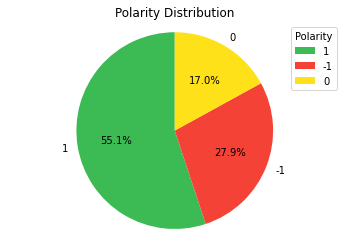

In [746]:
import pandas as pd
import matplotlib.pyplot as plt
# distribution of polarity
polarity_counts =df['polarity'].value_counts(normalize=True)

# assign colors for each category
colors = ['#3cba54', '#f44336', '#ffe119']

# Create a pie chart of the polarity distribution
plt.pie(polarity_counts.values, labels=polarity_counts.index, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Polarity Distribution')
plt.legend(title='Polarity', loc='best')
plt.show()

# TEXT

In [4]:
class ContentAttention(Layer):
    def __init__(self, **kwargs):
        super(ContentAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(ContentAttention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)   


# Bi-LSTM 

In [5]:
#import AveragePooling2D
from keras.layers import (AveragePooling1D)
from tensorflow.keras import regularizers

text_af = 'tanh'
text_input = Input(shape=(100,), name='text_input')

#----------LSTM1----------------
lstm1 = Embedding(input_dim=10000, output_dim=100)(text_input)
lstm1 = Dropout(0.5)(lstm1)  # Add a dropout layer
lstm1 = Bidirectional(LSTM(64, return_sequences=True))(lstm1)
#lstm1 = Dense(64, activation=text_af, kernel_regularizer=regularizers.l2(0.01))(lstm1)
lstm1 = ContentAttention()(lstm1)
lstm1 = Dropout(0.5)(lstm1)  # Add a dropout layer

#---------LSTM2-----------------
lstm2 = Embedding(input_dim=10000, output_dim=100)(text_input)
lstm2 = Dropout(0.5)(lstm2)  # Add a dropout layer
lstm2 = Bidirectional(LSTM(128, return_sequences=True))(lstm2)
#lstm2 = Dense(64, activation=text_af, kernel_regularizer=regularizers.l2(0.01))(lstm2)
lstm2 = ContentAttention()(lstm2)
lstm2 = Dropout(0.5)(lstm2)  # Add a dropout layer

#----------local fusion---------------
merged_layer = Concatenate()([lstm1, lstm2]) 
merged = Dense(3, activation='tanh')(merged_layer)
text_output = merged
textclassifier ='BiLSTM + BiLSTM'
print(textclassifier)

BiLSTM + BiLSTM


# Image

# CNN+CNN

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Concatenate, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

imageclassifier = 'CNN+ CNN + Attention'

# ------------ pipeline1:CNN --------------------------
image_input = Input(shape=(imagesize, imagesize, 3), name='image_input')
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
pool1 = Dropout(0.3)(pool1)
pool1 = BatchNormalization()(pool1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
pool2 = Dropout(0.3)(pool2)
pool2 = BatchNormalization()(pool2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
pool3 = Dropout(0.3)(pool3)
pool3 = BatchNormalization()(pool3)

#conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
#pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
#pool4 = Dropout(0.25)(pool4)
#pool4 = BatchNormalization()(pool4)

# Add spatial attention to CNN features
cnn1_attention = Conv2D(1, (1, 1), activation='sigmoid')(pool3)
attended_a = Multiply()([pool3, cnn1_attention])
cnn1_flatten = Flatten()(attended_a)


# ------------ pipeline2:CNN--------------------------
#image_input = Input(shape=(imagesize, imagesize, 3), name='image_input')
conv1b = Conv2D(64, (3, 3), activation='relu', padding='same')(image_input)
pool1b = MaxPooling2D(pool_size=(2, 2))(conv1b)
pool1b = Dropout(0.5)(pool1b)
pool1b = BatchNormalization()(pool1b)

conv2b = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1b)
pool2b = MaxPooling2D(pool_size=(2, 2))(conv2b)
pool2b = Dropout(0.5)(pool2b)
pool2b = BatchNormalization()(pool2b)

conv3b = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2b)
pool3b = MaxPooling2D(pool_size=(2, 2))(conv3b)
pool3b = Dropout(0.5)(pool3b)
pool3b = BatchNormalization()(pool3b)

#conv4b = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3b)
#pool4b = MaxPooling2D(pool_size=(2, 2))(conv4b)
#pool4b = Dropout(0.25)(pool4b)
#pool4b = BatchNormalization()(pool4b)

# Add spatial attention to CNN features
cnn2_attention = Conv2D(1, (1, 1), activation='sigmoid')(pool3b)
attended_b = Multiply()([pool3b, cnn2_attention])
cnn2_flatten = Flatten()(attended_b)


#----------local fusion---------------
merged = Concatenate()([cnn1_flatten, cnn2_flatten])

# Apply the rest of the model layers
merged = Dense(128, activation='relu')(merged)
merged = Dropout(0.3)(merged)
image_output = Dense(3, activation='relu', kernel_regularizer=regularizers.l2(0.01))(merged)

print(imageclassifier)

CNN+ CNN + Attention


# Fusion

In [7]:
from keras.optimizers import Adam, Adagrad, RMSprop
from keras import backend as K
from keras import metrics

#----------Global fusion---------------
concatenated = Concatenate()([text_output, image_output])
# Final output layers
output = Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(concatenated)
model = Model(inputs=[text_input, image_input], outputs=output)
print(file_path)
print(f"Text:{textclassifier},Image:{imageclassifier}")
# Compile the model
optimizer = Adam(learning_rate=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit([X_train_text, X_train_image], y_train, 
                    validation_data=([X_val_text, X_val_image], y_val),
                    epochs=10, 
                    batch_size=64)
# Evaluate the model
test_loss, test_acc = model.evaluate([X_test_text, X_test_image], y_test)
print('Test accuracy:', test_acc)


multi.txt
Text:BiLSTM + BiLSTM,Image:CNN+ CNN + Attention
Epoch 1/10
244/244 [==============================] - 352s 1s/step - loss: 0.8595 - accuracy: 0.7454 - val_loss: 0.7687 - val_accuracy: 0.7704
Epoch 2/10
244/244 [==============================] - 380s 2s/step - loss: 0.7709 - accuracy: 0.7418 - val_loss: 0.7078 - val_accuracy: 0.7704
Epoch 3/10
244/244 [==============================] - 395s 2s/step - loss: 0.6997 - accuracy: 0.7542 - val_loss: 0.6944 - val_accuracy: 0.7663
Epoch 4/10
244/244 [==============================] - 394s 2s/step - loss: 0.6554 - accuracy: 0.7600 - val_loss: 0.6993 - val_accuracy: 0.7422
Epoch 5/10
244/244 [==============================] - 360s 1s/step - loss: 0.6388 - accuracy: 0.7552 - val_loss: 0.6994 - val_accuracy: 0.7180
Epoch 6/10
244/244 [==============================] - 372s 2s/step - loss: 0.6240 - accuracy: 0.7457 - val_loss: 0.7025 - val_accuracy: 0.7704
Epoch 7/10
244/244 [==============================] - 358s 1s/step - loss: 0.6012 - 

# Metrics

In [8]:
from sklearn.metrics import classification_report
import numpy as np

# Make predictions on test data
y_pred = model.predict([X_test_text, X_test_image])

# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_true_classes, y_pred_classes, digits = 4)
print(f"image:{imageclassifier}, Text:{textclassifier}")
# Print the report
print('Classification Report:\n', report)


61/61 [==============================] - 9s 114ms/step
image:CNN+ CNN + Attention, Text:BiLSTM + BiLSTM
Classification Report:
               precision    recall  f1-score   support

           0     0.3333    0.0079    0.0154       254
           1     0.7832    0.9493    0.8583      1461
           2     0.3195    0.2338    0.2700       231

    accuracy                         0.7415      1946
   macro avg     0.4787    0.3970    0.3812      1946
weighted avg     0.6694    0.7415    0.6784      1946



# LATE FUSION

In [9]:
#----------------image----------------
image_feature_extractor = Model(inputs=image_input, outputs=image_output)

val_image_features = image_feature_extractor.predict(X_val_image)
test_image_features = image_feature_extractor.predict(X_test_image)

#--------------text----------------
text_feature_extractor = Model(inputs=text_input, outputs=text_output)

val_text_features = text_feature_extractor.predict(X_val_text)
test_text_features = text_feature_extractor.predict(X_test_text)

#---------------combine----------------
val_features = np.concatenate([val_image_features, val_text_features], axis=1)
test_features = np.concatenate([test_image_features, test_text_features], axis=1)

# one-hot encoded vectors if needed
y_val_labels = y_val_polar #np.argmax(y_val_image, axis=1)
y_test_labels = y_test_polar#np.argmax(y_test_image, axis=1)


61/61 [==============================] - 3s 52ms/step


## XGB

In [14]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_val_labels_encoded = label_encoder.fit_transform(y_val_labels)
y_test_labels_encoded = label_encoder.transform(y_test_labels)

xgb_model = xgb.XGBClassifier(n_estimators=120, max_depth=2) #reg_lambda reg_alpha

# Train the XGBoost model
xgb_model.fit(val_features, y_val_labels_encoded)

# Evaluate the model
xgb_score = xgb_model.score(test_features, y_test_labels_encoded)
print("Late Fusion Test Accuracy: {:.2f}%".format(xgb_score * 100))
print(f"image:{imageclassifier}, Text:{textclassifier}")
y_pred = xgb_model.predict(test_features)

# Print classification report
print(classification_report(y_test_labels_encoded, y_pred, digits=4))

Late Fusion Test Accuracy: 75.13%
image:CNN+ CNN + Attention, Text:BiLSTM + BiLSTM
              precision    recall  f1-score   support

           0     0.4750    0.1645    0.2444       231
           1     0.2963    0.0315    0.0569       254
           2     0.7700    0.9692    0.8582      1461

    accuracy                         0.7513      1946
   macro avg     0.5138    0.3884    0.3865      1946
weighted avg     0.6731    0.7513    0.6807      1946



## Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators=150, max_depth=12)

rf.fit(val_features, y_val_labels)
rf_score = rf.score(test_features, y_test_labels)
print("Late Fusion Test Accuracy: {:.2f}%".format(rf_score * 100))
#from sklearn.metrics import classification_report

# Predict labels for test data
y_pred = rf.predict(test_features)
print(f"image:{imageclassifier}, Text:{textclassifier}")
# Print classification report
print(classification_report(y_test_labels, y_pred, digits=4))

Late Fusion Test Accuracy: 75.03%
image:CNN+ CNN + Attention, Text:BiLSTM + BiLSTM
              precision    recall  f1-score   support

          -1     0.4000    0.1212    0.1860       231
           0     0.3529    0.0236    0.0443       254
           1     0.7671    0.9760    0.8590      1461

    accuracy                         0.7503      1946
   macro avg     0.5067    0.3736    0.3631      1946
weighted avg     0.6694    0.7503    0.6728      1946



## MLP

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# Create an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(256, 32), 
                    activation='relu', solver='lbfgs', learning_rate = 'invscaling')

# Fit the classifier to the training data
mlp.fit(val_features, y_val_labels)

# Evaluate the classifier on the test data
mlp_score = mlp.score(test_features, y_test_labels)
print("Late Fusion Test Accuracy: {:.2f}%".format(mlp_score * 100))

# Predict labels for the test data
y_pred = mlp.predict(test_features)

# Print classification report
print(classification_report(y_test_labels, y_pred, digits=4))

Late Fusion Test Accuracy: 73.43%
              precision    recall  f1-score   support

          -1     0.2388    0.0693    0.1074       231
           0     0.2500    0.0236    0.0432       254
           1     0.7585    0.9630    0.8486      1461

    accuracy                         0.7343      1946
   macro avg     0.4158    0.3520    0.3331      1946
weighted avg     0.6304    0.7343    0.6555      1946



C:\Users\ausco\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


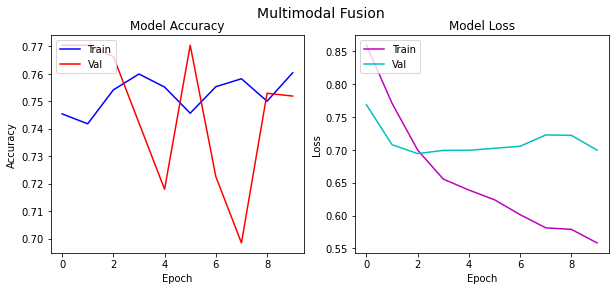

In [19]:
plot16.plot_hist(history, 'Multimodal Fusion')

61/61 [==============================] - 6s 106ms/step


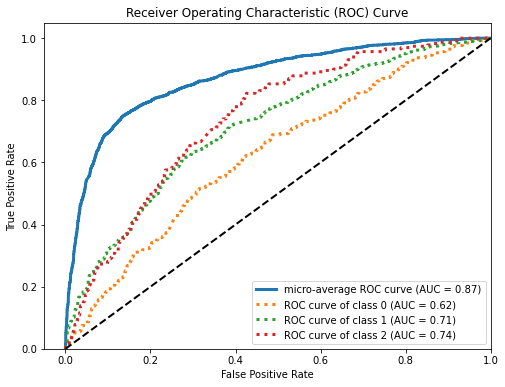

In [20]:
X_test = [X_test_text, X_test_image]
plot16.plot_roc(model, X_test, y_test)